In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils.utils_vis import title_font_size, axis_font_size, ticks_font_size, width_in_inches, pk_param_names, pk_param_units, pk_bounds
from matplotlib.gridspec import GridSpec
import pandas as pd

save = False
pred_paths = {
    'PINN-ens' : 'output/vivo/pinn_ph_dcenet_ens/predictions',
    'MVE-ens' : 'output/normal/mve_snn_dcenet_ens/predictions',
}
colors = ['tab:cyan', 'lime']
# coords = [82, 120]
coords_aorta = [120, 82] #x,y
# coords_liver = [50, 60] #x,y
coords_liver = [65, 54] #x,y


In [2]:
if save:
    outpath = "output/vis_report_final"
    for subfolder in ["aleatoric", "epistemic", "vivo", "appendix"]:
        if not os.path.exists(f"{outpath}/{subfolder}"):
            os.makedirs(f"{outpath}/{subfolder}")

Load slice

In [3]:
slice = np.load('data/vivo/slice1.npz')

slice_mask = slice['mask']
slice_ct = slice['ct']
slice_shape = slice_ct.shape

Load predictions

In [4]:
predictions = { name: 
        np.load(os.path.join(path, 'test_slices.npz'), allow_pickle=True)['slice1'].item() 
    for name, path in pred_paths.items()}

# Load the uncertainty slices, including the zero voxels to maintain shape
pred_epistemic_uncertainty_slices = { name: 
                              predictions[name]["var_ep"][:,[0,2,3]].reshape(slice_shape[:2]+(-1,))
                              for name in predictions.keys()}

# Load a flat array of nonzero voxel predicitons for quantitative analysis
pred_epistemic_uncertainty_masked = {
    name: 
    pred_epistemic_uncertainty_slices[name][slice_mask==1].reshape([-1,3])
    for name in predictions.keys()}

reconstructions = { name: 
                   predictions[name]["reconstruction"].reshape(slice_shape[:2]+(80,)) 
                   for name in predictions.keys()}

reconstruction_erorrs = { name: 
                         np.abs(reconstructions[name] - slice_ct).mean(axis=-1) * slice_mask 
                         for name in predictions.keys()}

Set in pandas dataframe format

In [5]:
# Flatten and prepare data for all models/parameters
records = []

for key, variances in pred_epistemic_uncertainty_masked.items():
    for i, param_name in enumerate(pk_param_names):
        param_variances = variances[..., i]
        param_variances = param_variances[param_variances > 0]  # Keep positive values
        for v in param_variances:
            records.append({
                "Uncertainty": v,
                "Model": key,
                "Parameter": param_name
            })

# Create a long-form DataFrame for Seaborn
df = pd.DataFrame.from_records(records)

## Plot
make gridspec

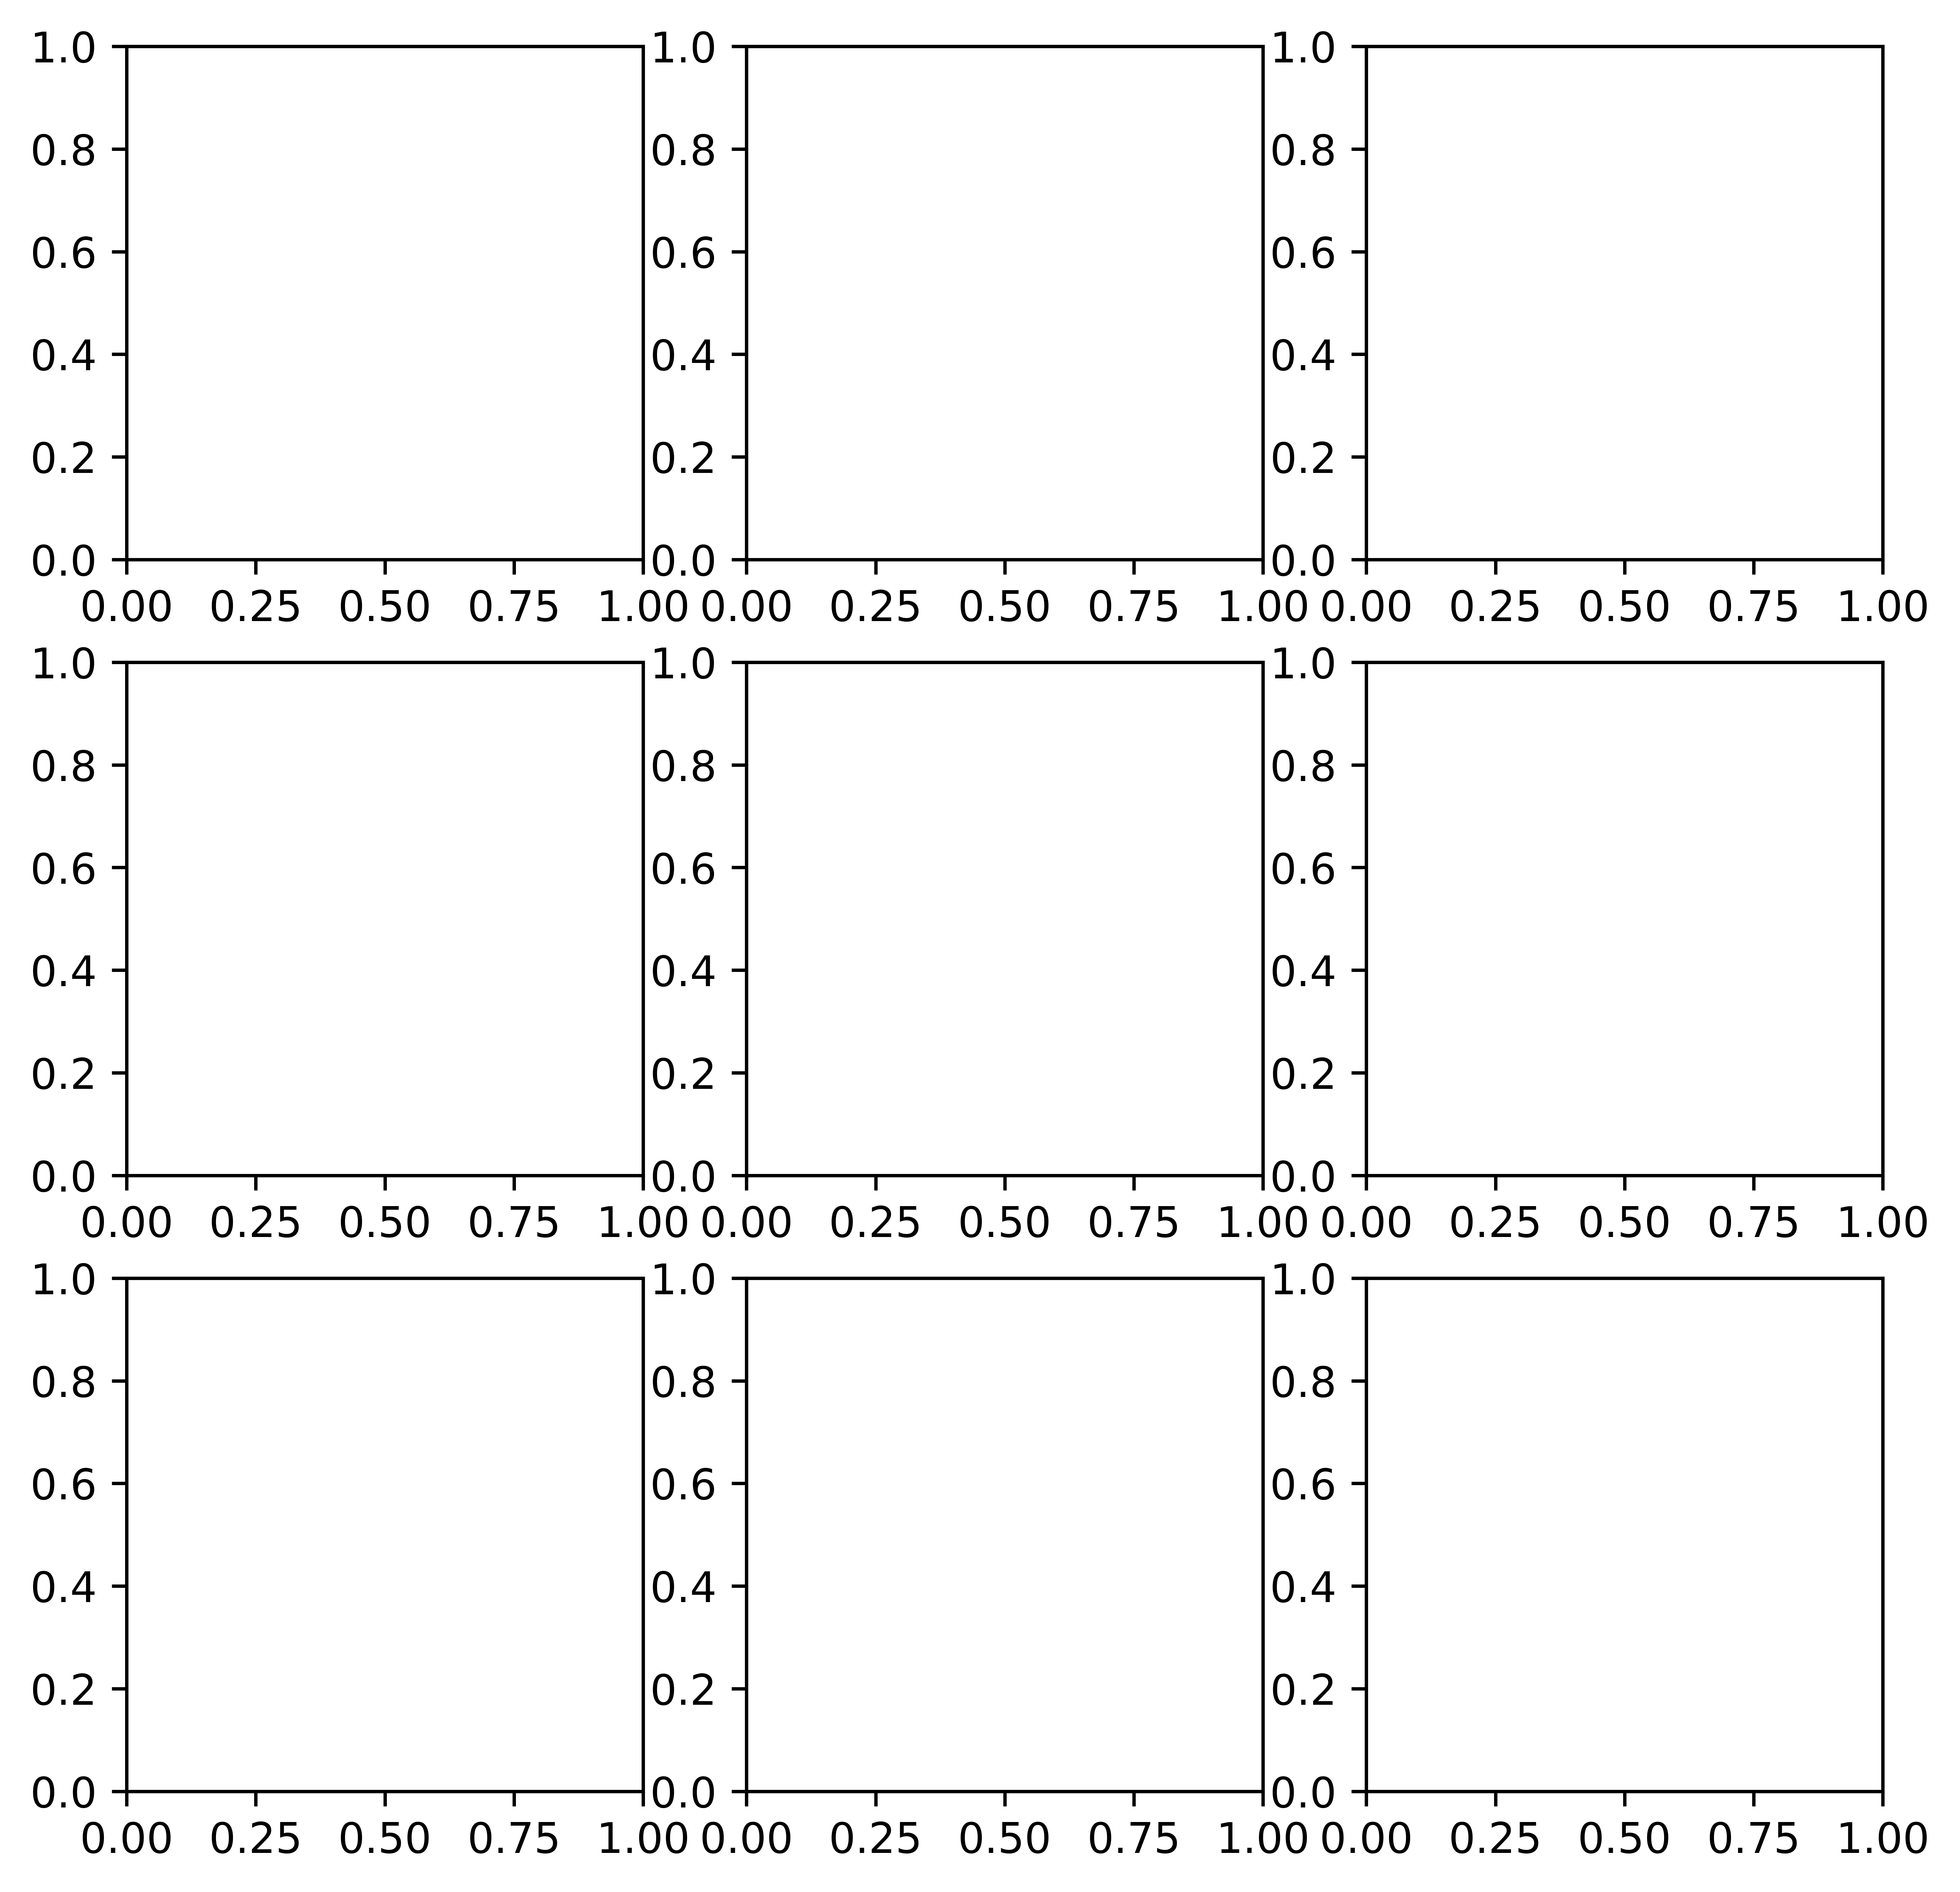

In [6]:
fig = plt.figure(figsize=(width_in_inches, width_in_inches), dpi=1000)
gs = GridSpec(3, 3, figure=fig)



# Row 2 - UCT slices
axs_row2 = [fig.add_subplot(gs[0, i]) for i in range(3)]

# Row 3A - Recon error
ax_3a = fig.add_subplot(gs[1, 0])

# Row 3B - Example curve spanning two subplots
ax_3b = fig.add_subplot(gs[1, 1]);
ax_3c = fig.add_subplot(gs[1, 2]);

# Row 1 - ECDF plots
axs_row1 = [fig.add_subplot(gs[2, i]) for i in range(3)]



Add the first row - ECDF plots

In [7]:
for i, param_name in enumerate(pk_param_names):
    ax = axs_row1[i]
    ax.clear()
    ax.set_title(f"{param_name}", fontsize=axis_font_size)
    sns.ecdfplot(
        data=df[df["Parameter"] == param_name],
        x="Uncertainty",
        hue="Model",
        ax=ax,
        log_scale=True,
        legend=False,
        complementary=True,
        hue_order=['MVE-ens'],
    )
    ax.set_xlabel("$\\sigma^2_e$", fontsize=axis_font_size)
    if i ==0:
        ax.set_ylabel("Proportion of Samples", fontsize=axis_font_size)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='both', which='major', labelsize=ticks_font_size)

    # plot vline at the epistemic uncertainty estimate of MVE at coords
    # for model, color in zip(pred_paths.keys(), colors):
    #     ax.axvline(
    #         x=pred_epistemic_uncertainty_slices[model][coords[1], coords[0], i],
    #         color=color,
    #         linestyle='--',
    #         label=model
    #     )
    for coords, color in zip([coords_aorta, coords_liver], colors):
        ax.axvline(
            x=pred_epistemic_uncertainty_slices['MVE-ens'][coords[1], coords[0], i],
            color=color,
            linestyle='--',
            label=f"{pk_param_names[i]} @ {coords}"
        )
    # ax.axvline(
    #     x=pred_epistemic_uncertainty_slices['MVE-ens'][coords[1], coords[0], i],
    #     color='tab:cyan',
    #     linestyle='--',
    #     label='Selected voxel'
    # )
    if i == 2:
        # manually add legend with the selected voxel and the models
        ax.legend(
            labels=['ECDF', 'Aorta', 'Liver'],
            loc='upper right',
            fontsize=ticks_font_size
        )
        # ax.legend(fontsize=ticks_font_size, loc='lower left')
fig.canvas.draw()
fig.tight_layout()
fig 

Add the uncertainty maps

In [8]:

for i, param_name in enumerate(pk_param_names):
    ax = axs_row2[i]
    ax.clear()

    # Draw image
    im = ax.imshow(
        pred_epistemic_uncertainty_slices['MVE-ens'][:,:,i] * slice_mask,
        cmap='inferno',
        vmin=0,
        vmax=[0.08, 0.001, 0.0005][i],
        interpolation='none'
    )

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.6, location = 'left')
    cbar.ax.tick_params(labelsize=ticks_font_size)
    cbar.ax.ticklabel_format(style='sci', scilimits=(-3, 4))
    cbar.set_label("$\\sigma^2_e$", fontsize=axis_font_size, rotation=0, labelpad=10)


    # Add x at coords
    ax.plot(coords_aorta[0], coords_aorta[1], 'x', color=colors[0], markersize=5)
    ax.plot(coords_liver[0], coords_liver[1], 'x', color=colors[1], markersize=5)
    ax.set_title(f"{param_name} uncertainty", fontsize=axis_font_size)

    # Remove junk
    ax.set_xticks([])
    ax.set_yticks([])
    # if i == 0:
    #     ax.set_ylabel("Epistemic Uncertainty", fontsize=axis_font_size, labelpad=20)

fig.canvas.draw()
fig.tight_layout()
fig

<Figure size 640x480 with 0 Axes>

In [9]:
# Reconstruction error
ax = ax_3a
ax.clear()
ax.imshow(
    reconstruction_erorrs['MVE-ens'],
    cmap='inferno',
    vmin=0,
    vmax=np.percentile(reconstruction_erorrs['MVE-ens'], 95),
    interpolation='none'
)

cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', shrink=0.6, location='left')
cbar.ax.tick_params(labelsize=ticks_font_size)
cbar.ax.ticklabel_format(style='sci', scilimits=(-3, 4))
# add cbar label
cbar.set_label("$mM$", fontsize=axis_font_size, rotation=0, labelpad=10)
ax.set_xticks([])
ax.set_yticks([])

ax.plot(coords_aorta[0], coords_aorta[1], 'x', color=colors[0], markersize=5)
ax.plot(coords_liver[0], coords_liver[1], 'x', color=colors[1], markersize=5)
ax.set_title("Reconstruction Error", fontsize=axis_font_size)


fig.canvas.draw()
fig.tight_layout()
fig


<Figure size 640x480 with 0 Axes>

In [10]:
# Curve
curve_axs = [ax_3b, ax_3c]
titles = ["Aorta", "Liver"]
time_in_minutes = np.arange(0, 80) / 60 * 4
for coords, color, ax, title in zip([coords_aorta, coords_liver], colors, curve_axs, titles):
    ax.clear()
    ax.plot(time_in_minutes, slice_ct[coords[1], coords[0]], label='Input', color='black', linewidth=1.0)
    # ax.plot(time_in_minutes, reconstructions["PINN-ens"][coords[1], coords[0]], label='PINN-ens', alpha=1.0, linestyle='--', color=color, linewidth=1.0)
    ax.plot(time_in_minutes, reconstructions["MVE-ens"][coords[1], coords[0]], label='MVE-ens fit', alpha=1.0, linestyle='-', color=color, linewidth=1.0)

    ax.tick_params(axis='both', which='major', labelsize=ticks_font_size)
    ax.legend(fontsize=ticks_font_size)
    ax.set_xlabel('Time (min)', fontsize=axis_font_size)
    ax.set_ylabel('Concentration ($mM$)', fontsize=axis_font_size)
    
    ax.set_title(f"Voxel in {title}", fontsize=axis_font_size)


fig.canvas.draw()
fig.tight_layout()
fig

In [11]:
# save fig
# save=True
if save:
    fig.savefig(
        os.path.join(outpath, "vivo", "epistemic_uncertainty_condensed.jpg"),
        dpi=1000,
        bbox_inches='tight'
    )